<b>Exercise 3: Big Areas</b>

Download a picture of the island of Luxembourg. You will note that the area of Luxembourg is too
large, meaning that it doesn't fit in a single Sentinel image. Download a set of Sentinel tiles that
together cover all the area of the country.

<i><b>IMPORT SECTION</b></i>

In [12]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import itertools
import numpy as np
import datetime
import utils
import os
os.environ['PROJ_LIB'] = './libraries/proj-7.2.0-h3e70539_1/Library/share'
from shapely.geometry import shape, Polygon, MultiPolygon, MultiLineString
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as plt_polygon
from mpl_toolkits.basemap import Basemap
from sentinelhub import BBoxSplitter, OsmSplitter, TileSplitter, BBox, read_data, CRS, DataCollection, \
MimeType, SentinelHubRequest, SentinelHubDownloadClient, bbox_to_dimensions, DownloadRequest, SHConfig


<i><b>CONFIGURATION SECTION</b></i>

In [13]:
config = SHConfig()
config.instance_id = 'c156dc38-84e6-4e95-8c36-73de5637636a'
config.sh_client_id = 'e1a9bfc8-e283-4adf-971d-2c3d71787d9c'
config.sh_client_secret = 'B@DS2;sB8,k!qeGrXkxa?Rr3zC3bUt,M[a+7l5qf'
if config.instance_id == '':
    print("Warning! To use WFS functionality, please configure the `instance_id`.")
    
data_folder = './data'
INPUT_FILE = './data/stanford-xf244by7385-geojson.json' #downloaded from https://maps.princeton.edu/catalog/stanford-xf244by7385

<i><b>FUNCTIONS SECTION</b></i>

In [14]:
#Collecting the data
def get_geo_json_data(INPUT_FILE):
    geo_json = read_data(INPUT_FILE)
    shapely_area = shape(geo_json["features"][0]["geometry"])
    return shapely_area

#Area Splitting
def show_splitter(splitter, alpha=0.2, area_buffer=0.2, show_legend=False):
    area_bbox = splitter.get_area_bbox()
    minx, miny, maxx, maxy = area_bbox
    lng, lat = area_bbox.middle
    w, h = maxx - minx, maxy - miny
    minx = minx - area_buffer * w
    miny = miny - area_buffer * h
    maxx = maxx + area_buffer * w
    maxy = maxy + area_buffer * h
    
    fig=plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
     
    base_map = Basemap(projection='mill', lat_0=lat, lon_0=lng, llcrnrlon=minx, llcrnrlat=miny,
                       urcrnrlon=maxx, urcrnrlat=maxy, resolution='l', epsg=4326)
    base_map.drawcountries(color=(0, 0, 0, 0))
    
    area_shape = splitter.get_area_shape()
    if isinstance(area_shape, Polygon):
        area_shape = [area_shape]
    for polygon in area_shape:
        if isinstance(polygon.boundary, MultiLineString):
            for linestring in polygon.boundary:
                ax.add_patch(plt_polygon(np.array(linestring), closed=True, facecolor=(0, 0, 0, 0), edgecolor='red'))
        else:
            ax.add_patch(plt_polygon(np.array(polygon.boundary), closed=True, facecolor=(0, 0, 0, 0), edgecolor='red'))
    
    bbox_list = splitter.get_bbox_list()
    info_list = splitter.get_info_list()
    
    cm = plt.get_cmap('jet', len(bbox_list))
    legend_shapes = []
    for i, (bbox, info) in enumerate(zip(bbox_list, info_list)):
        wgs84_bbox = bbox.transform(CRS.WGS84).get_polygon()

        tile_color = tuple(list(cm(i))[:3] + [alpha])
        ax.add_patch(plt_polygon(np.array(wgs84_bbox), closed=True, facecolor=tile_color, edgecolor='green'))
        
        if show_legend:
            legend_shapes.append(plt.Rectangle((0,0),1,1, fc=cm(i)))
    
    if show_legend:
        legend_names = []
        for info in info_list:
            legend_name = '{},{}'.format(info['index_x'], info['index_y'])
            
            for prop in ['grid_index', 'tile']:
                if prop in info:
                    legend_name = '{},{}'.format(info[prop], legend_name)
            
            legend_names.append(legend_name)
        
        plt.legend(legend_shapes, legend_names)
    plt.tight_layout()
    plt.show()

#Splitting in satellite's tile grid
def split_satellite_tiles(shapely_area, time_inteval):
    tile_splitter = TileSplitter(
        [shapely_area],
        CRS.WGS84,
        time_inteval,
        data_collection=DataCollection.SENTINEL2_L1C,
        config=config
    )

    return tile_splitter

def get_true_color_request(time_interval, selected_bbox, selected_size):
    evalscript_true_color = """
        //VERSION=3

        function setup() {
            return {
                input: [{
                    bands: ["B02", "B03", "B04"]
                }],
                output: {
                    bands: 3
                }
            };
        }

        function evaluatePixel(sample) {
            return [sample.B04, sample.B03, sample.B02];
        }
    """
    return SentinelHubRequest(
        evalscript=evalscript_true_color,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L1C,
                time_interval=time_interval,
                mosaicking_order='leastCC'
            )
        ],
        responses=[
            SentinelHubRequest.output_response('default', MimeType.PNG)
        ],
        bbox=selected_bbox,
        size=selected_size,
        data_folder=data_folder,
        config=config
    )

def plot_image(image, factor=1.0, clip_range = None, **kwargs):
    """
    Utility function for plotting RGB images.
    """
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
    if clip_range is not None:
        ax.imshow(np.clip(image * factor, *clip_range), **kwargs)
    else:
        ax.imshow(image * factor, **kwargs)
    ax.set_xticks([])
    ax.set_yticks([])
    

<i><b>EXECTUTION SECTION</b></i>

In [15]:
time_interval = ('2017-10-01', '2018-03-01')
luxembourg_area = get_geo_json_data(INPUT_FILE)
tile_splitter = split_satellite_tiles(luxembourg_area, time_interval)
tile_bbox_list = tile_splitter.get_bbox_list()

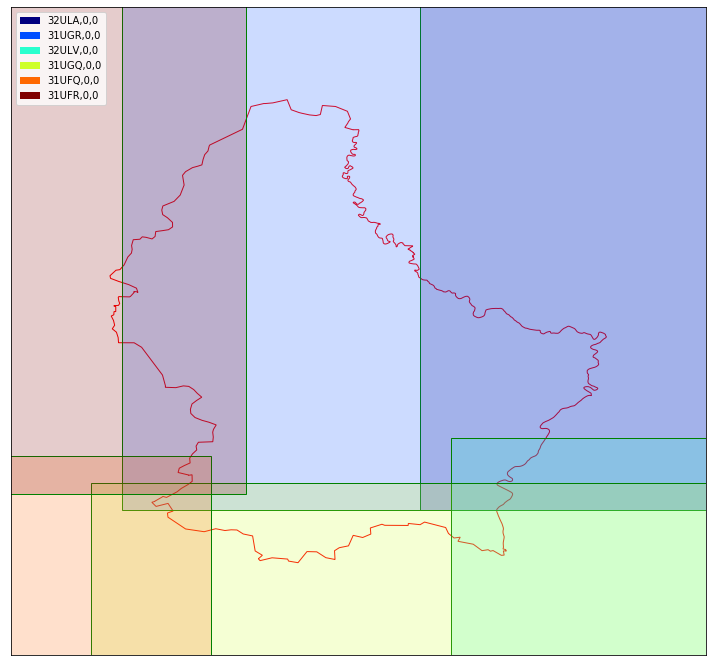

In [16]:
#Displaying the tiles
show_splitter(tile_splitter, show_legend=True)

In [17]:
selected_bbox=tile_bbox_list[0]
selected_size=bbox_to_dimensions(tile_bbox_list[0], resolution=60)

response =  get_true_color_request(time_interval,selected_bbox,selected_size)
true_color_imgs = response.get_data()

Selected tipe area shape: 


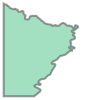

In [20]:
#Displaying the area shape of a selected tile
geometry_list = tile_splitter.get_geometry_list()
print('Selected tipe area shape: ')
geometry_list[0]

Selected tile area image - type: uint8


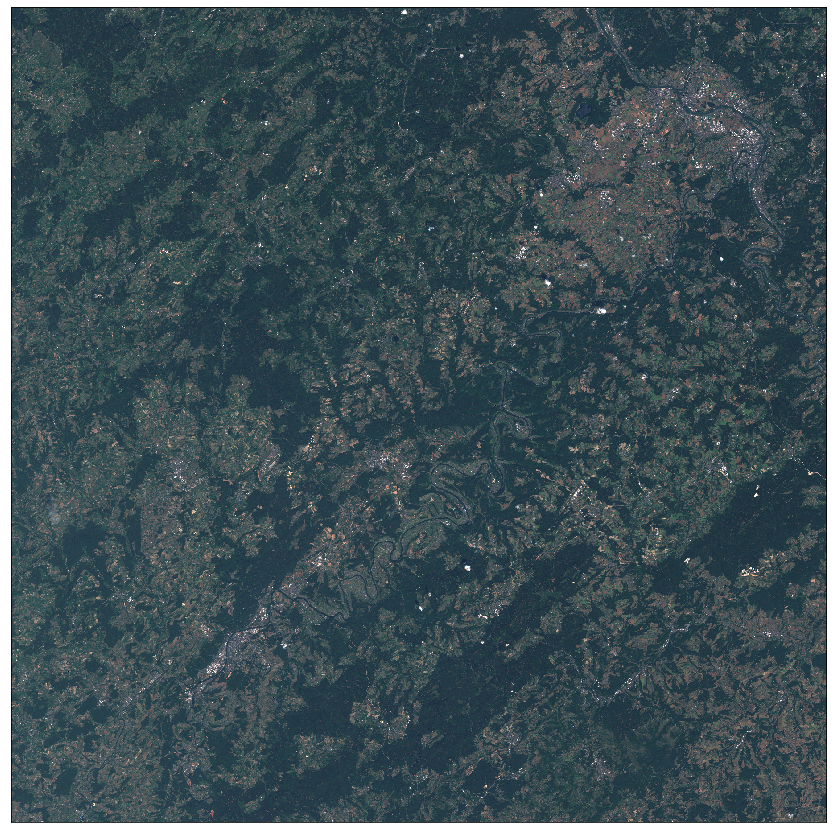

In [21]:
#Displaying the image from the selected tile
image = true_color_imgs[0]
print(f'Selected tile area image - type: {image.dtype}')

#plot function
#factor 1/255 to scale between 0-1
#factor 3.5 to increase brightness
plot_image(image, factor=3.5/255, clip_range=(0,1))

In [18]:
#Creating a list of download requests
list_of_requests = [get_true_color_request(time_interval, selected_bbox, selected_size) for selected_bbox in tile_bbox_list]

In [19]:
#Downloading all the images in the "data_folder"
for request in list_of_requests:
    request.get_data(save_data=True, redownload=True) 